In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from IPython.display import Markdown, display

In [2]:
# Load Temperature Data from NetCDF
temp_ds = xr.open_dataset("C:/Users/VINCENT/Desktop/CAN/Calabar_data.nc")

In [3]:
# Display variable names and coordinates
temp_ds

<xarray.Dataset>
Dimensions:     (valid_time: 720, latitude: 5, longitude: 5)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2025-04-01 ... 2025-04-30T23:00:00
  * latitude    (latitude) float64 5.5 5.25 5.0 4.75 4.5
  * longitude   (longitude) float64 8.0 8.25 8.5 8.75 9.0
    expver      (valid_time) object ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-11T04:38 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
# Define bounding box for 1x1 degree around Calabar
lat_bounds = [4.95, 5.0]
lon_bounds = [8.20, 8.25]

In [5]:
# Select the region from the dataset
subset = temp_ds.sel(latitude=slice(*lat_bounds[::-1]), longitude=slice(*lon_bounds))

In [6]:
# Display variable names and coordinates
subset

<xarray.Dataset>
Dimensions:     (valid_time: 720, latitude: 1, longitude: 1)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2025-04-01 ... 2025-04-30T23:00:00
  * latitude    (latitude) float64 5.0
  * longitude   (longitude) float64 8.25
    expver      (valid_time) object ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-11T04:38 GRIB to CDM+CF via cfgrib-0.9.1...

In [7]:
# Calculate average temperature over time and space
avg_temp = subset['t2m'].mean(dim=['latitude', 'longitude', 'valid_time'])

In [8]:
# Convert from Kelvin to Celsius
avg_temp_celsius = avg_temp - 273.15

display(Markdown(f"""#### 🌡️ **Average Temperature:** {avg_temp_celsius:.2f}°C"""))

#### 🌡️ **Average Temperature:** 27.50°C

In [9]:
# Load the air quality CSV data
air_quality_df = pd.read_csv("C:/Users/VINCENT/Desktop/CAN/openaq_location_1894640_measurments.csv")

In [10]:
# Preview air quality data
air_quality_df.head()

,location_id,location_name,parameter,value,unit,datetimeUtc,datetimeLocal,timezone,latitude,longitude,country_iso,isMobile,isMonitor,owner_name,provider
0,1894640,Calabar,pm25,9.57,µg/m³,2025-04-01T03:04:54Z,2025-04-01T04:04:54+01:00,Africa/Lagos,5.02529,8.34843,NaN,NaN,NaN,Clarity,Clarity
1,1894640,Calabar,pm25,9.09,µg/m³,2025-04-01T03:22:19Z,2025-04-01T04:22:19+01:00,Africa/Lagos,5.02529,8.34843,NaN,NaN,NaN,Clarity,Clarity
2,1894640,Calabar,pm25,8.61,µg/m³,2025-04-01T03:39:44Z,2025-04-01T04:39:44+01:00,Africa/Lagos,5.02529,8.34843,NaN,NaN,NaN,Clarity,Clarity
3,1894640,Calabar,pm25,9.30,µg/m³,2025-04-01T03:57:10Z,2025-04-01T04:57:10+01:00,Africa/Lagos,5.02529,8.34843,NaN,NaN,NaN,Clarity,Clarity
4,1894640,Calabar,pm25,11.89,µg/m³,2025-04-01T04:14:35Z,2025-04-01T05:14:35+01:00,Africa/Lagos,5.02529,8.34843,NaN,NaN,NaN,Clarity,Clarity


In [11]:
# Convert datetimeUtc to datetime
air_quality_df['datetime'] = pd.to_datetime(air_quality_df['datetimeUtc'])
air_quality_df.set_index('datetime', inplace=True)

In [12]:
# Resample to hourly mean values
pm25_hourly = air_quality_df[air_quality_df['parameter'] == 'pm25']['value'].resample('1h').mean()
pm25_hourly = pm25_hourly.reset_index().rename(columns={'value': 'pm25'})

In [13]:
# Resample to hourly mean values
pm25_hourly['datetime'] = pm25_hourly['datetime'].dt.tz_localize(None)

In [14]:
# Extract average temperature over the 5x5 grid
t2m_mean = temp_ds['t2m'].mean(dim=['latitude', 'longitude'])

# Compute the spatial mean (over lat and lon) for each time step
t2m_df = t2m_mean.to_dataframe().reset_index()

# Merge the datasets again on datetime
t2m_df.rename(columns={'valid_time': 'datetime', 't2m': 'temperature_2m'}, inplace=True)

# Convert to pandas DataFrame
merged_df = pd.merge(t2m_df, pm25_hourly, on='datetime', how='inner')

In [15]:
# Drop NaNs to ensure clean covariance calculation
merged_df_clean = merged_df.dropna(subset=['temperature_2m', 'pm25'])

In [16]:
merged_df_clean

,datetime,number,expver,temperature_2m,pm25
0,2025-04-01 03:00:00,0,0005,297.902832,9.142500
1,2025-04-01 04:00:00,0,0005,297.863708,13.696667
2,2025-04-01 05:00:00,0,0005,298.392151,16.830000
3,2025-04-01 06:00:00,0,0005,298.706390,22.530000
4,2025-04-01 07:00:00,0,0005,299.285217,13.720000
...,...,...,...,...,...
512,2025-04-22 11:00:00,0,0005,302.613403,9.610000
513,2025-04-22 12:00:00,0,0005,303.724396,6.737500
514,2025-04-22 13:00:00,0,0005,303.303528,5.976667
515,2025-04-22 14:00:00,0,0005,302.784698,6.202500


In [17]:
## Calculate covariance matrix

covariance_matrix = merged_df_clean[['temperature_2m', 'pm25']].cov()
covariance_matrix

,temperature_2m,pm25
temperature_2m,5.867971,-5.081900
pm25,-5.081900,59.572124


In [18]:
## Covariance summary/interpretation

#- The value of –0.5082 means:
#- As temperature increases, PM2.5 tends to decrease — they move in opposite directions.
#- The negative covariance confirms the same trend as correlation:
#- Higher temperatures are loosely associated with lower PM2.5 levels.
#- But the magnitude of –0.5082 is not interpretable on its-
#- own without knowing the units and scale of both variables.

In [19]:
# Convert temperature to Celsius for interpretability (optional)

merged_df_clean = merged_df_clean.copy()
merged_df_clean['temperature_celsius'] = merged_df_clean['temperature_2m'] - 273.15

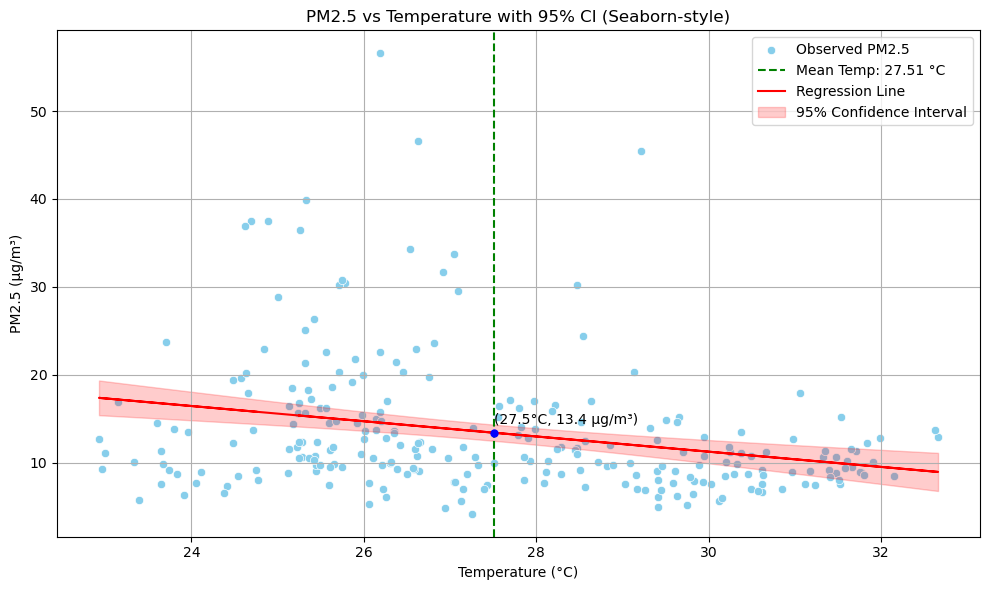

In [20]:
## Plotting line regression fit (with confidence interval like seaborn regplot)

# Sample data
x = merged_df_clean['temperature_celsius']
y = merged_df_clean['pm25']

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept
avg_temp_celsius = x.mean()
predicted_pm25 = slope * avg_temp_celsius + intercept
y_intercept = intercept
x_intercept = -intercept / slope

# Confidence interval (95%)
X = sm.add_constant(x)  # adds intercept term
model = sm.OLS(y, X).fit()
predictions = model.get_prediction(X)
summary_frame = predictions.summary_frame(alpha=0.05)  # 95% CI

# Ensure x and CIs are clean and aligned
ci_x = x.reset_index(drop=True)
ci_lower = summary_frame['mean_ci_lower'].reset_index(drop=True)
ci_upper = summary_frame['mean_ci_upper'].reset_index(drop=True)

# Sort x and associated CIs together
sorted_indices = ci_x.argsort()
ci_x = ci_x.iloc[sorted_indices]
ci_lower = ci_lower.iloc[sorted_indices]
ci_upper = ci_upper.iloc[sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y, color='skyblue', label='Observed PM2.5')
plt.axvline(avg_temp_celsius, color='green', linestyle='--', label=f'Mean Temp: {avg_temp_celsius:.2f} °C')
plt.scatter(avg_temp_celsius, predicted_pm25, color='blue', zorder=5, s=25)
plt.plot(x, summary_frame['mean'], color='red', label='Regression Line')
plt.fill_between(ci_x, ci_lower, ci_upper,
                 color='red', alpha=0.2, label='95% Confidence Interval')
plt.text(avg_temp_celsius, predicted_pm25 + 1,
         f"({avg_temp_celsius:.1f}°C, {predicted_pm25:.1f} µg/m³)",
         color='black', ha='left')
plt.xlabel('Temperature (°C)')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('PM2.5 vs Temperature with 95% CI (Seaborn-style)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   pm25   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     20.02
Date:                Wed, 28 May 2025   Prob (F-statistic):           1.16e-05
Time:                        04:30:16   Log-Likelihood:                -865.81
No. Observations:                 253   AIC:                             1736.
Df Residuals:                     251   BIC:                             1743.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  37.2205      5.345      6.964      0.000      26.694      47.747
temperature_celsius    -0.8660      0.194     -4.475      0.000      -1.247      -0.485
==============================================================================
Omnibus:                      140.043   Durbin-Watson:                   0.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              754.186
Skew:                           2.266   Prob(JB):                    1.70e-164
Kurtosis:                      10.142   Cond. No.                         316.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
## Line regression model and plot interpretation

#- Steeper line indicates stronger sensitivity: meaning that a small change in temperature-
#- leads to a large change in PM2.5.
#- flatter line indicates weaker relationship: PM2.5 doesn't change much with temperature.
#- But even if the slope is steep or flat you must check R-square(coefficient of determination).
#- R-square close to 1: indicates that temperature explains most of the variance in PM2.5.
#- R-square near 0: means that temperature explains little to no variance.
#- If the confidence interval for the slope does not include 0, the slope is statistically significant-
#- (i.e., there's evidence of a real linear relationship).
#- This is also shown by the Lower and Upper bound in the OLS summary table.

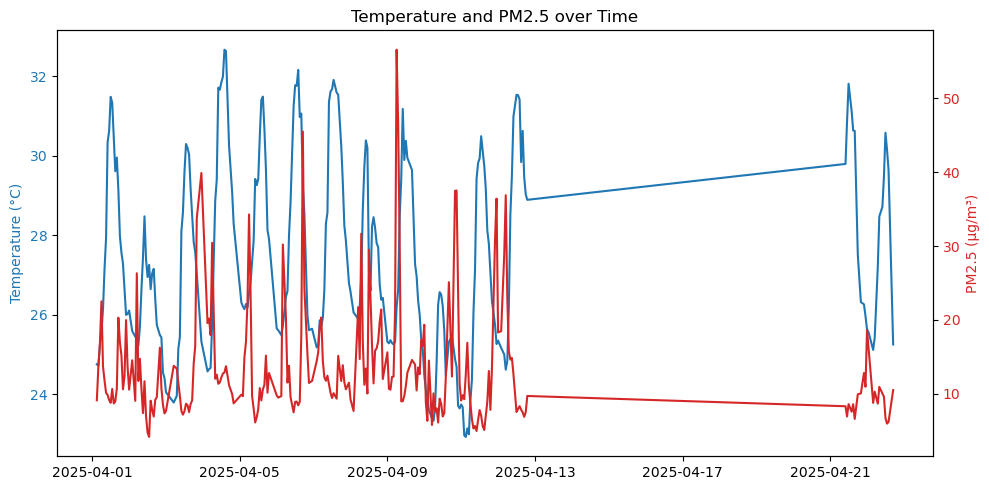

In [23]:
## Time Series Plot

fig, ax1 = plt.subplots(figsize=(10, 5))

# Temperature
ax1.plot(merged_df_clean['datetime'], merged_df_clean['temperature_celsius'], color='tab:blue', label='Temperature (°C)')
ax1.set_ylabel("Temperature (°C)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# PM2.5 (second axis)
ax2 = ax1.twinx()
ax2.plot(merged_df_clean['datetime'], merged_df_clean['pm25'], color='tab:red', label='PM2.5 (µg/m³)')
ax2.set_ylabel("PM2.5 (µg/m³)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Temperature and PM2.5 over Time")
plt.tight_layout()
plt.show()

In [24]:
## Time Series Plot Summary:

# For the Date part
merged_df_clean = merged_df_clean.copy()
merged_df_clean['date'] = pd.to_datetime(merged_df_clean['datetime'], errors='coerce')
merged_df_clean.set_index('date', inplace=True)

# To calculate the trend, first define delta and direction
# Calculate PM2.5 change over time
delta = merged_df_clean['pm25'].iloc[-1] - merged_df_clean['pm25'].iloc[0]

# Determine direction of change
direction = "increased" if delta > 0 else "decreased"


display(Markdown(f"""
### 📊 Time Series Summary (April 2025)
- **Start Date:** {merged_df_clean.index.min().strftime('%Y-%m-%d')}
- **End Date:** {merged_df_clean.index.max().strftime('%Y-%m-%d')}
- **Observations:** {merged_df_clean.shape[0]}
- **Mean:** {merged_df_clean['pm25'].mean():.2f} µg/m³, {merged_df_clean['temperature_celsius'].mean():.2f} °C
- **Median:** {merged_df_clean['pm25'].median():.2f} µg/m³, {merged_df_clean['temperature_celsius'].median():.2f} °C
- **Min:** {merged_df_clean['pm25'].min():.2f} µg/m³, {merged_df_clean['temperature_celsius'].min():.2f} °C
- **Max:** {merged_df_clean['pm25'].max():.2f} µg/m³, {merged_df_clean['temperature_celsius'].max():.2f} °C
- **Std Dev:** {merged_df_clean['pm25'].std():.2f} µg/m³, {merged_df_clean['temperature_celsius'].std():.2f} °C
- **Trend:** PM2.5 has {direction} by {delta:.2f} µg/m³
"""))


### 📊 Time Series Summary (April 2025)
- **Start Date:** 2025-04-01
- **End Date:** 2025-04-22
- **Observations:** 253
- **Mean:** 13.40 µg/m³, 27.51 °C
- **Median:** 11.08 µg/m³, 27.06 °C
- **Min:** 4.18 µg/m³, 22.93 °C
- **Max:** 56.57 µg/m³, 32.66 °C
- **Std Dev:** 7.72 µg/m³, 2.42 °C
- **Trend:** PM2.5 has increased by 1.38 µg/m³


In [25]:
## Time series plot interpretation

#- Hourly Temperature/PM2.5 levels change significantly (i.e., High Volatility feature).
#- since there's lack of smooth trend, establishing a clear upward/downward trend is difficult.
#- This also suggests that short-term influences highly affects the behaviour at hourly level.
#- Unstable enviroment, frequent shifts in emissions or weather may also be a likely cause.
#- The behaviour of both against temperature exposes there high sensitivity to time and external factors.
#- There's no obvious pattern of synchronization between temperature and PM2.5-
#- (i.e., peaks amd troughs have no alignment).
#- Flat areas may indicate missing or zero readings, or change in atmospheric conditions.

In [26]:
merged_df_clean

,datetime,number,expver,temperature_2m,pm25,temperature_celsius
date,,,,,,
2025-04-01 03:00:00,2025-04-01 03:00:00,0,0005,297.902832,9.142500,24.752838
2025-04-01 04:00:00,2025-04-01 04:00:00,0,0005,297.863708,13.696667,24.713715
2025-04-01 05:00:00,2025-04-01 05:00:00,0,0005,298.392151,16.830000,25.242157
2025-04-01 06:00:00,2025-04-01 06:00:00,0,0005,298.706390,22.530000,25.556396
2025-04-01 07:00:00,2025-04-01 07:00:00,0,0005,299.285217,13.720000,26.135223
...,...,...,...,...,...,...
2025-04-22 11:00:00,2025-04-22 11:00:00,0,0005,302.613403,9.610000,29.463409
2025-04-22 12:00:00,2025-04-22 12:00:00,0,0005,303.724396,6.737500,30.574402
2025-04-22 13:00:00,2025-04-22 13:00:00,0,0005,303.303528,5.976667,30.153534


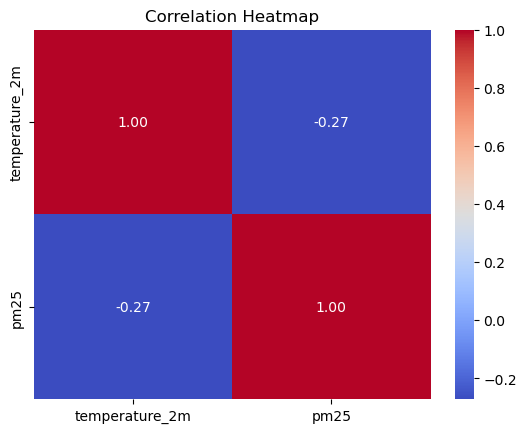

In [27]:
## Heatmap (Correlation Matrix)

corr_matrix = merged_df_clean[['temperature_2m', 'pm25']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [28]:
## Correlation Heatmap summary/interpretation

#- The covariance between temperature and PM2.5 is –0.51,
#- indicating that as temperature rises,
#- PM2.5 concentrations tend to decrease.
#- This trend is also reflected in the correlation coefficient (–0.27),
#- which shows a weak negative linear relationship.

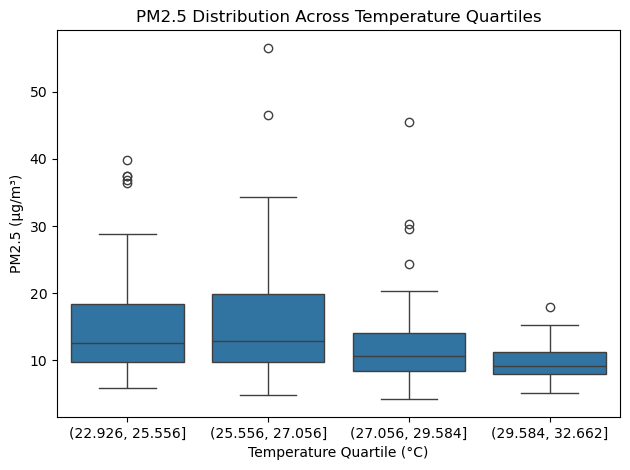

In [29]:
## Box Plot

merged_df_clean = merged_df_clean.copy()
merged_df_clean['temp_bin'] = pd.qcut(merged_df_clean['temperature_celsius'], q=4)
sns.boxplot(x='temp_bin', y='pm25', data=merged_df_clean)
plt.xticks(rotation=0)
plt.title("PM2.5 Distribution Across Temperature Quartiles")
plt.xlabel("Temperature Quartile (°C)")
plt.ylabel("PM2.5 (µg/m³)")
plt.tight_layout()
plt.show()

In [30]:
## Box Plot Summary:

q1 = merged_df_clean['pm25'].quantile(0.25)
q2 = merged_df_clean['pm25'].quantile(0.50)
q3 = merged_df_clean['pm25'].quantile(0.75)
min_val = merged_df_clean['pm25'].min()
max_val = merged_df_clean['pm25'].max()
iqr = q3 - q1
outliers = merged_df_clean[(merged_df_clean['pm25'] < (q1 - 1.5 * iqr)) | (merged_df_clean['pm25'] > (q3 + 1.5 * iqr))]

display(Markdown(f"""
### 📦 Box Plot Summary (April 2025)

- **Min:** {min_val:.2f} µg/m³  
- **Q1 (25th percentile):** {q1:.2f} µg/m³  
- **Median (Q2):** {q2:.2f} µg/m³  
- **Q3 (75th percentile):** {q3:.2f} µg/m³  
- **Max:** {max_val:.2f} µg/m³  
- **IQR:** {iqr:.2f} µg/m³  
- **Outliers:** {outliers.shape[0]}
"""))



### 📦 Box Plot Summary (April 2025)

- **Min:** 4.18 µg/m³  
- **Q1 (25th percentile):** 8.79 µg/m³  
- **Median (Q2):** 11.08 µg/m³  
- **Q3 (75th percentile):** 15.15 µg/m³  
- **Max:** 56.57 µg/m³  
- **IQR:** 6.36 µg/m³  
- **Outliers:** 19


In [31]:
## Box plot interpretation

#- There are several dots appearing above the top whiskers: hinting pollution spikes
#- But low median(closer to the bottom) means clean air.
#- Box plot shows high variability at lower temperature range and low variability-
#- at high temperature range (maybe the reason for the gentle slope in line regression plot)
#- Short box means data is concentrated, hinting low variability.
#- Box is shifted down, thus indicating skewed data distribution.
#- Median position, in the above is positioned near the buttom, meaning skewed distribution.
#- Low IQR, hints short box.